# Casadi Pymola Demo

In [244]:
%matplotlib inline
from pymola.backends.casadi.api import transfer_model
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

First, we load a simple exponential model.

In [245]:
model = transfer_model('../models/', 'Exponential', {})

In [246]:
model

Model
time: time
states: [x[1,1]:float]
der_states: [der(x)[1,1]:float]
alg_states: []
inputs: [u[1,1]:float]
outputs: []
constants: []
parameters: []
equations: [MX((der(x)-(u-x)))]
initial equations: []

## Optimal Control

We wish to find an optimal input sequence $U$ so that we reach $x=1$ at $t=1$.

subject to:

$ \dot{x} = f(t, x, u_k) $



In [247]:
dae = model.dae_residual_function
X0 = model.states[0].start

# Discretization time step
dt = 0.1
tf = 1
N = int(tf/dt)

# Optimization variables and bounds
X = ca.MX.sym('X', N)
lbX = np.full(N, -np.inf)
ubX = np.full(N, np.inf)

U = ca.MX.sym('U', N)
lbU = np.full(N, 0)
ubU = np.full(N, 1.75)

# Collocate DAE using backwards Euler method
g = []
i = 0
res = dae(0, X[0], (X[0] - X0) / dt, U[0], U[i], ca.MX(), ca.MX())
g.append(res)
for i in range(1, N):
    res = dae(i * dt, X[i], (X[i] - X[i - 1]) / dt, ca.MX(), U[i], ca.MX(), ca.MX())
    g.append(res)
    
# Optimization objective
f = (X[-1] - 1.0)**2

# Solve NLP
nlp = {'x': ca.vertcat(X, U), 'f': f, 'g': ca.vertcat(*g)}
ipopt_options = {'tol': 1e-6, 'print_level': 1}
solver = ca.nlpsol('nlp', 'ipopt', nlp, {'ipopt': ipopt_options})
solution = solver(lbx=ca.vertcat(lbX, lbU), ubx=ca.vertcat(ubX, ubU), lbg=0, ubg=0)
T = np.linspace(0, N * dt, N + 1)
X = solution['x'][0:N]
X = np.vstack([[X0], X])[:, 0]
U = solution['x'][N:2*N]
U = np.vstack([U, [U[-1]]])[:, 0]

               t_proc [s]   t_wall [s]    n_eval
         nlp      0.00446      0.00446         1
       nlp_f      2.4e-05     2.28e-05        10
       nlp_g     0.000234     0.000233        10
  nlp_grad_f        6e-05     5.83e-05        11
  nlp_hess_l     0.000467     0.000467         9
   nlp_jac_g     0.000932     0.000934        11


# Simulation

Using our optimal input, we create a function to implement the optimal control law for our system.

In [248]:
import scipy.interpolate
u_interp = scipy.interpolate.interp1d(T, U, kind="zero", fill_value="extrapolate")
def f_control(t, x, p):
    # we choose to disengage input after 1 second
    if t<0 or t>1:
        u = 0
    else:
        u = u_interp(t)
    return u
f_control(0, 1, {})

array(1.53393165)

Now we simulate the system. Note we can use a much smaller time step if necessary here than in the optimizaiton problem and see what happens.

In [249]:
data = model.sim(dt=0.001, tf=1.5, x0=0, f_u = f_control)

Finally, we can plot the results. Notice that our discretized points from the optimization problem are plotted on top of the simulation results as points. The simulation result is plotted as a line. We choose to disengage the input after 2 seconds, so the state decays.

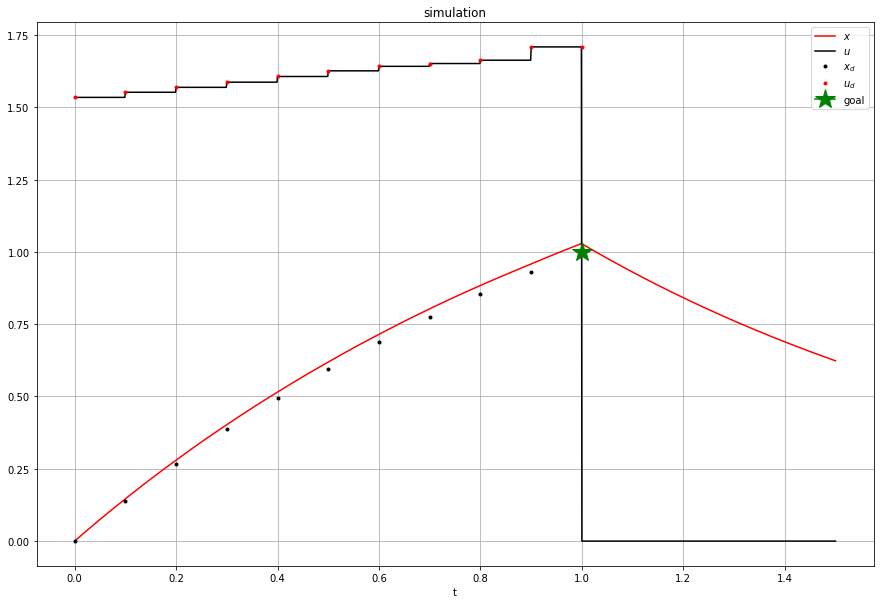

In [250]:
def plot_data(data):
    plt.plot(data['t'], data['x'], 'r-', label="$x$")
    plt.plot(data['t'], data['u'], 'k-', label="$u$")
    plt.plot(T, X, 'k.', label="$x_{d}$")
    plt.plot(T, U, 'r.', label="$u_{d}$")
    plt.plot(1, 1, label="goal", color='green', marker='*', markersize=20)
    plt.grid()
    plt.legend()
    plt.xlabel('t')
    plt.title('simulation');

plt.figure(figsize=(15, 10))
plot_data(data)